# Learning to reset in target search problems

In this notebook, we exemplify how to train agents in a target search problems, similar to the foraging problems we deal with in the rest of this library. In this case we consider a single target. 

The agents we consider here have an important addition: they are able to reset to the origin. As we show in our paper ([link]()), this helps agents reach much better efficiencies compared to a non-resetting strategy.

Let's start this tutorial by importing some necesarry libraries:

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numba

# Reset 1D

We will first exemplify the flow of the presented approach with the paradigmatic case of Reset in 1D. Let's first define, for the rest of this example, what are the diffusion coefficient of the agents (both learning and fixed), and the target distances we will look at:

In [ ]:
# Diffusion coefficient
D = 1/2
# Target distances
Ls = np.arange(5, 11)

## Sharp and exponential

We start by looking at the sharp and exponential resetting strategies. We start by defining the parameters for each strategy:

In [ ]:
# Reset rate for exponential
rates = np.logspace(-2.5,-1.25,100 )

# Reset time for sharp
resets = np.linspace(5, 250, 100).astype(np.int64)

Now we perform a simulation of the target search problem for each strategy and parameter. The library contains functions that launch a parallel simulation over the number of resets / rates, based on the number of cores you have:

In [ ]:
from rl_opts.rl_framework.numba.environments import parallel_Reset1D_exp, parallel_Reset1D_sharp


Feel free to increase `reps` to get better results (for the paper we used `reps = 1e5`).

In [ ]:
reps = int(1e3)
time_ep = int(1e4)
rews_exp = np.zeros((reps, len(Ls), len(rates)))
rews_sharp = np.zeros((reps, len(Ls), len(resets)))

for idxL, L in enumerate(tqdm(Ls)):

    for idxr in range(reps):
    
        rews_exp[idxr, idxL] = parallel_Reset1D_exp(time_ep, rates, L, D)
        
        rews_sharp[idxr, idxL] = parallel_Reset1D_sharp(time_ep, resets, L, D)

We can now plot the efficiencies of each resetting time for the sharp distribution:

Text(0.5, 1.0, 'Sharp reset')

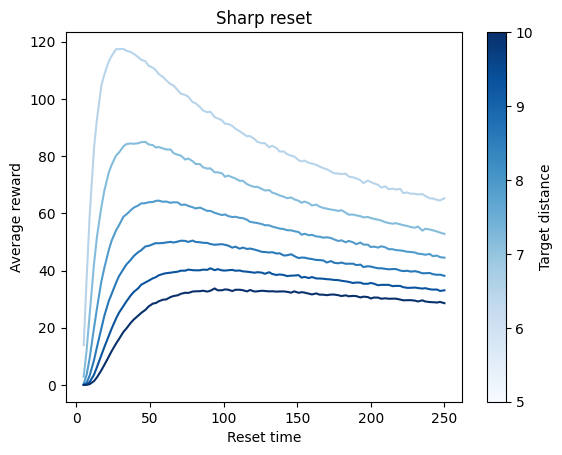

In [ ]:
# create a Blues color map so that I can plot each line with a different blue tone
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.3, 1, len(Ls)))

fig, ax = plt.subplots()

for i in range(len(Ls)):
    ax.plot(resets, rews_sharp.mean(0)[i], c = colors[i])

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=Ls.min(), vmax=Ls.max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Target distance')

ax.set_xlabel('Reset time')
ax.set_ylabel('Average reward')
ax.set_title('Sharp reset')

and for each rate of the exponential distribution:

Text(0.5, 1.0, 'Exponential reset')

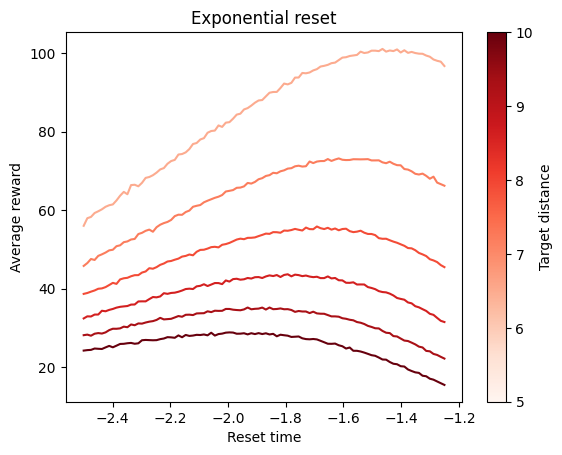

In [ ]:
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0.3, 1, len(Ls)))

fig, ax = plt.subplots()

for i in range(len(Ls)):
    ax.plot(np.log10(rates), rews_exp.mean(0)[i], c = colors[i])

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=Ls.min(), vmax=Ls.max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Target distance')

ax.set_xlabel('Reset time')
ax.set_ylabel('Average reward')
ax.set_title('Exponential reset')

## Learning

### Didactic implementation: training a single agent

Here we will focus on implementing all steps of a training loop in a didactic way.

We start by defining the RL agent. We use the `Forager` provided by the library:

In [ ]:
from rl_opts.rl_framework.numba.agents import Forager

In [ ]:
# Number of actions of the agent. here we consider 2 actions: diffuse or reset.
num_actions = 2

# Size of the state space: in the current context, means the maximum counter the agent can reach before compulsory turning
size_state_space = np.array([int(2e3)])

# For the PS parameter, we choose the best parameters we chose from a grid search (see below how to do it)
gamma_damping = 3e-6
eta_glow_damping = 0.12


# We now define the agent (may take time in the first run due to numba compilation
Reset_agent = Forager(num_actions, 
                      size_state_space,
                      gamma_damping, eta_glow_damping)

Next we define the Reset environment:

In [ ]:
from rl_opts.rl_framework.numba.environments import ResetEnv_1D


Reset_env = ResetEnv_1D(L = Ls[0], # Distance of the target to the origin. We consider for this example the first distance from above.
                  D = D # Diffusion coefficient of the agent
                 )

Finally, we perform the RL training loop:

In [ ]:
# Number of episodes
episodes = 300 
# Number of steps per episode (we use same as above for the sharp and exponential)
time_ep = int(1e4)

# To keep track of the obtained rewards
save_rewards = np.zeros(episodes)

for ep in tqdm(range(episodes)):
        
        # Initialize the environment and agent's counter and g-matrix
        Reset_env.init_env()
        Reset_agent.agent_state = 0
        Reset_agent.reset_g()

        for t in range(time_ep):

            # The efficient agent we created needs to keep track when the last
            # update to the h_matrix happened. 
            Reset_agent.N_upd_H += 1
            Reset_agent.N_upd_G += 1

            # Get the agent's state (i.e. its current counter)
            # This differs a bit from typical RL scenarios in which the state comes from the environment,
            # but changes nothing in terms of the whole RL loop.
            state = Reset_agent.get_state()
            
            # If we reached the maximum state space, we perform turn action
            if state == Reset_agent.h_matrix.shape[-1]:
                action = 1
            # Else we sample an action from the agent's policy
            else: 
                action = Reset_agent.deliberate(state)
                
            # Now we implement this action into the state, which here means updating the agent's counter.
            # Again, this is slightly different from typical RL where the action is implemented in the environment,
            # but actually changes nothing to a normal RL implementation (see paper for details)
            Reset_agent.act(action)

            # We now update the position of the agent in the environment. This also checks if the agnet reached a target
            # and return a reward = 1 if so.
            reward = Reset_env.update_pos(action)            

            # If we got a reward or reached the maximum no update value for the H_matrix (for efficient agents), we update 
            # the h_matrix
            if reward == 1 or Reset_agent.N_upd_H == Reset_agent.max_no_H_update-1:
                Reset_agent._learn_post_reward(reward)

            # Now we make sure that the state of the agent (counter = 0) is updated if we got the reward
            if reward != 0:
                Reset_agent.agent_state = 0

            # We keep track of the number of rewards obtained:
            save_rewards[ep] += reward

We can now see how the agent learned by plotting the rewards (i.e. targets acquired) per episode. We will also compare to the best sharp and exponential strategies (horizontal line):

Text(0, 0.5, 'Rewards')

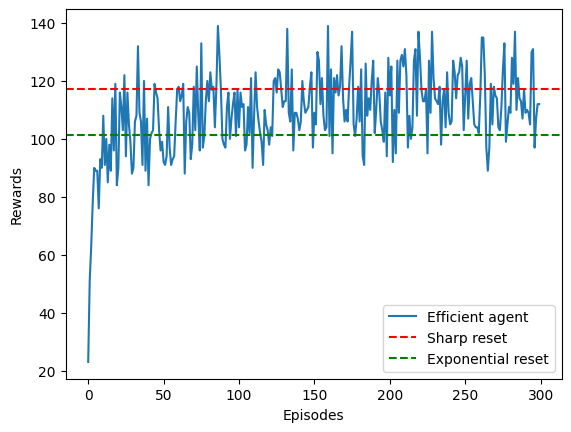

In [ ]:
plt.plot(save_rewards, label = 'Efficient agent')


plt.axhline(rews_sharp.mean(0)[0].max(), color = 'red', linestyle = '--', label = 'Sharp reset')
plt.axhline(rews_exp.mean(0)[0].max(), color = 'green', linestyle = '--', label = 'Exponential reset')


plt.legend()

plt.xlabel('Episodes')
plt.ylabel('Rewards')

We can see that with only few episodes, the agent is already able to go from a very bad initial strategy to something that outperforms the exponential strategy and closely matches the efficiency of the sharp resetting!

#### Agent's strategy
In our paper we showed how the strategy learned by the agent converges to the sharp reset strategy. To do so, we have to look at the agent's policy, defined in this case by its h-matrix. 

> This figures corresponds to Figure 3a from our paper.

Text(0, 0.5, 'Probability of the reset action')

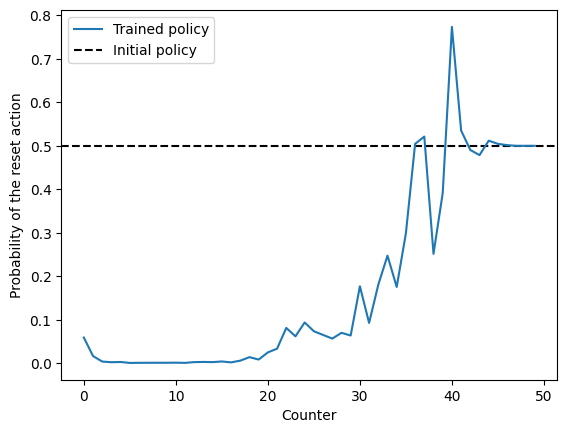

In [ ]:
# The policy is calculated by normalizing the h_matrix
policy_reset = Reset_agent.h_matrix[1] / Reset_agent.h_matrix.sum(0)

# Let's plot the first points of the policy. Beyond this, the policy converges to the initial policy
# at 0.5, because the agent will always reset after reaching those counter values.
plt.plot(policy_reset[:50], label = 'Trained policy')

plt.axhline(0.5, color = 'k', linestyle = '--', label = 'Initial policy', zorder = -1)

plt.legend()
plt.xlabel('Counter')
plt.ylabel('Probability of the reset action')

### Grid Search and Multi-Agent Training

The `rl_opts` library provides functionality for parallel training of multiple agents, enabling comprehensive benchmarking of their efficiencies. This feature allows us to perform grid searches and compare the performance of different agents under various conditions.

In [ ]:
from rl_opts.rl_framework.numba.agents import run_agents_reset_1D


We start by defining the training specifications. For the paper, in the case of Reset 1D, we used the following:

| Parameter            | Value                                      |
|----------------------|--------------------------------------------|
| Episodes             | 1000                                       |
| Steps per episdoe              | 5000                                       |
| Number of agents     | 190                                        |
| multiplier_agents    | 5                                          |
| D                    | 0.5                                        |
| Distances (as defined above)        | `np.arange(5, 15)`                         |
| Maximum counter value| 2000                         |
| $\gamma$               | `np.logspace(-9, -5.5, 10)`                |
| $\eta$                | `np.linspace(0.05, 0.3, 10)`               |


> **Important:** the next cell can take quite long to run, depending on your computational capabilities. We have set at a minimum such that you can still perform some analysis from the outputs. If you just want to explore how the function works, decrease the number of episodes, the number of steps per episode, as well as the number of gammas and etas explored.

In [ ]:
# Training specs. Commented are the original values used in the paper, but we will use a smaller numbers for this example
episodes = int(1e2) # paper: int(1e3)
time_ep = int(5e2) # paper: int(5e3)

# Number of agents, defined here by the numbe of cores available multiplied by the number
# of runs we want to perform (multiplier_agents)
num_cores = int(numba.get_num_threads()*0.8)
multiplier_agents = 5


# Size of the state space: in the current context, means the maximum counter the agent can reach before compulsory turning
size_state_space = np.array([int(2e3)])

# Projective simulation parameters
gammas = np.logspace(-9, -5.5, 10)
etas = np.linspace(0.05, 0.3, 10)

# Now we loop over the different parameters and distances
rews = np.zeros((len(Ls), len(gammas), len(etas), num_cores*multiplier_agents, episodes))
for idxL, L in enumerate(tqdm(Ls)):
    for idxg, gamma in enumerate(gammas):
        for idxe, eta in enumerate(etas):

            # Now we run the parallel training. This function spits out the rewards and the h_matrices. We will only keep the rewards
            # here. The h_matrices were used during our analysis to create the plots of the policies (as the example above) as well
            # as the analysis of the resetting times.
            rews[idxL, idxg, idxe], h_matrices = run_agents_reset_1D(episodes = int(episodes), time_ep = int(time_ep), 
                                                                    N_agents = num_cores,
                                                                    num_runs = multiplier_agents,
                                                                    D = D, L = L,
                                                                    size_state_space = size_state_space,
                                                                    gamma_damping = gamma,
                                                                    eta_glow_damping = eta, 
                                                                    )

  0%|          | 0/6 [00:00<?, ?it/s]

We can now take a look at how the average accuracy was for the grid of parameters at each distance:

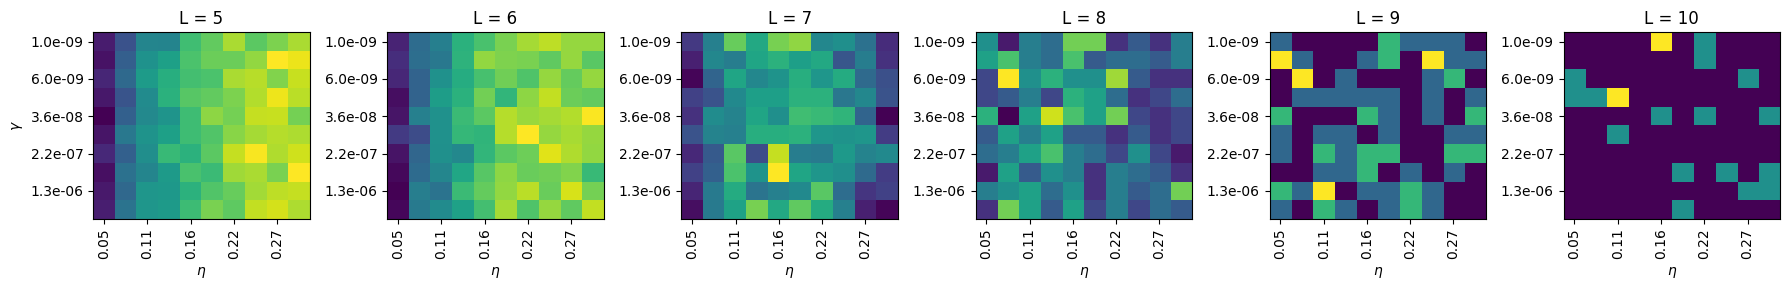

In [ ]:
fig, axs = plt.subplots(1, len(Ls), figsize=(3*len(Ls), 3))

for idxL, L in enumerate(Ls):
    avg_efficiency = rews[idxL, :, :, :, -1].mean(axis=-1)
    cax = axs[idxL].matshow(avg_efficiency, aspect='auto')
    axs[idxL].set_title(f'L = {L}')

    axs[idxL].set_xticks(np.arange(0, len(etas), 2))
    axs[idxL].set_xticklabels([f'{etas[i]:.2f}' for i in range(0, len(etas), 2)], rotation=90)
    axs[idxL].set_yticks(np.arange(0, len(gammas), 2))
    axs[idxL].set_yticklabels([f'{gammas[i]:.1e}' for i in range(0, len(gammas), 2)])

    axs[idxL].xaxis.set_ticks_position('bottom')

    if idxL == 0:
        axs[idxL].set_ylabel(r'$\gamma$')
    axs[idxL].set_xlabel(r'$\eta$')

plt.tight_layout()
plt.show()


Here, yellow means a bigger efficiency. This plots have been created with very few epsiodes, hence their noise. Running them for 100x episodes would lead to much clearer plots. The best parameters for each $L$ were the following:

| |      |  |
|-----|----------------|--------|
|  $L$  | $\gamma$       | $\eta$   |
| 5   | 3.16e-06       | 0.122   |
| 6   | 1.29e-06       | 0.122   |
| 7   | 5.27e-07       | 0.151   |
| 8   | 5.27e-07       | 0.151   |
| 9   | 3.59e-08       | 0.206   |
| 10  | 1.00e-09       | 0.220   |

# Reset 2D

For the Reset agents in 2D, we use exactly the same procedure as for the previous, but changing to the following environment:

In [ ]:
from rl_opts.rl_framework.numba.environments import ResetEnv_2D

In [ ]:
env_reset_2D = ResetEnv_2D(dist_target = 5, # Distance of the target to the origin
                           radius_target = 1, # Radius of the target
                           D = 1 # Diffusion coefficient of the agent
                           )

Then, the exact same loop we used above would directly work with this new environment. The library also contains a function to perform the training of multiple agents in parallel in this 2D scenarion, namely:

In [ ]:
from rl_opts.rl_framework.numba.agents import run_agents_reset_2D

This functions works exactly the same as above, just changing `L` for `dist_target` and `radius_target` in the function, as for instance:

In [ ]:
rewards, h_matrices = run_agents_reset_2D(episodes = 10, time_ep = 20, N_agents = 5, # These are the same as above
                                            # New params of this function
                                            dist_target = 10.0,
                                            radius_target = 1.0,
                                            D = 1,
                                            # The rest of the parameters are optional, you can take inspiration
                                            # from the run_agents_reset example.
                                            )   

# Turn-Reset 2D

We will now showcase how to train Turn-Reset agents. In essence, it is exactly the same as we did with the previous agents. The only difference is that these agents have access to 3 different actions: continue in the same direction, turn to a random direction (also implying a step, to avoid the agent spinning indefinitely) and the reset action. We suggest you first read the details of the construction of the agents in the paper and later come to this tutorial.

To cope for this, we created a new environment:

In [ ]:
from rl_opts.rl_framework.numba.environments import TurnResetEnv_2D

In [ ]:
env_TurnRes = TurnResetEnv_2D(dist_target = 6, # Distance of the target to the origin
                              radius_target = 1, # Radius of the target
                              # In this case, the agent is not diffusing but rather performing steps of
                              # constant size. The following variable defines the size of the steps.
                              agent_step = 1
                              )

The previous environment performs the actions as following:

In [ ]:
# Let's first initialize the environment, i.e. setting the position to the origin
env_TurnRes.init_env()


# This is a continue step
env_TurnRes.update_pos(# change_direction
                       False, 
                       # reset
                       False)

# This is a turn step
env_TurnRes.update_pos(# change_direction
                       True, 
                       # reset
                       False)

# This is a reset step
env_TurnRes.update_pos(# change_direction
                       False, 
                       # reset
                       True);

## Sharp resetting
Our proposed baseline for this problem is again a sharp resetting strategy. For the turning time, we will also consider a sharp strategy. Indeed, in our work we found that the best turning point is at $\sim L + 1$ (see paper for details). 

If you want to play with the sharp baseline, inputting arbitray reset and turning times, you can do with the following:

In [ ]:
from rl_opts.rl_framework.numba.environments import search_loop_turn_reset_sharp

In [ ]:
turn = env_TurnRes.dist_target + 1 
reset = env_TurnRes.dist_target + 2

length_sharp_run = int(1e7) # Feel free to increase to get a better estimate

efficiency_sharp = search_loop_turn_reset_sharp(T = length_sharp_run, # Number of steps of the search
                                    reset = reset, # After how many steps to reset
                                    turn = turn, # After how many steps to turn
                                    env = env_TurnRes # The environment
                                    )

## Didactic example: training a single agent
As before, let's start with the basics! We will first define the new environment and agent. For the later, it is actually the same agent `Forager`, but with now 3 actions:

In [ ]:
# Number of actions of the agent, 3: continue, turn and reset.
num_actions = 3

# Size of the state space. Because now we have two counters (turn and reset), the state space is 2D.
size_state_space = np.array([100, 100])

# For the PS parameter, we performed a grid search and found the best parameters as shown above
# IMPORTANT: these parameters were indeed used for all distances in the paper!
gamma_damping = 1.93e-6
eta_glow_damping = 0.086


# We now define the agent (may take time in the first run due to numba compilation
TurnReset_agent = Forager(num_actions, 
                        size_state_space,
                        gamma_damping, eta_glow_damping)

In [ ]:
# Number of episodes
episodes = 300 
# Number of steps per episode (we use same as above for the sharp and exponential)
time_ep = int(1e4)

save_rewards = np.zeros(episodes)

for ep in tqdm(range(episodes)):
    #initialize environment and agent's counter and g matrix
    # Improve documentation

    # Initialize the environment and the agent's counters and g-matrix
    env_TurnRes.init_env()

    turn_counter = 0
    reset_counter = 0

    TurnReset_agent.reset_g()

    for t in range(time_ep):

        # Update counters for matrices updates

        # The efficient agent we created needs to keep track when the last
        # update to the h_matrix happened. 
        TurnReset_agent.N_upd_H += 1
        TurnReset_agent.N_upd_G += 1    


        # Get the agent's state (i.e. its current counter)
        state = np.array([turn_counter, reset_counter])
        
        # Get the action from the agent's policy 
        action = TurnReset_agent.deliberate(state)
            
        # Update the counters based on the action. This would
        # typically be done inside of the environment, but because the state
        # is in the case inherent to the agent, we have to do it here.
        if action == 0: # Continue
            turn_counter += 1  
            reset_counter += 1 

        elif action == 1: # Turn
            turn_counter = 0  
            reset_counter += 1 

        elif action == 2: # Reset            
            # Note that resetting also resets the turn counter, as we sample a new direction
            turn_counter = 0     
            reset_counter = 0 
            
        
        # We now send the action to the environment to update the position
        reward = env_TurnRes.update_pos(True if action == 1 else False, 
                                        True if action == 2 else False)

        # If we got a reward or reached the maximum no update value for the H_matrix (for efficient agents), we update
        # the h_matrix
        if reward == 1:
            TurnReset_agent._learn_post_reward(reward)            

            # After receiving a reward, we also reset the counters
            turn_counter = 0
            reset_counter = 0                

        if TurnReset_agent.N_upd_H == TurnReset_agent.max_no_H_update-1:
            TurnReset_agent._learn_post_reward(reward)
                
        # Saving the reward
        save_rewards[ep] += reward

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Rewards')

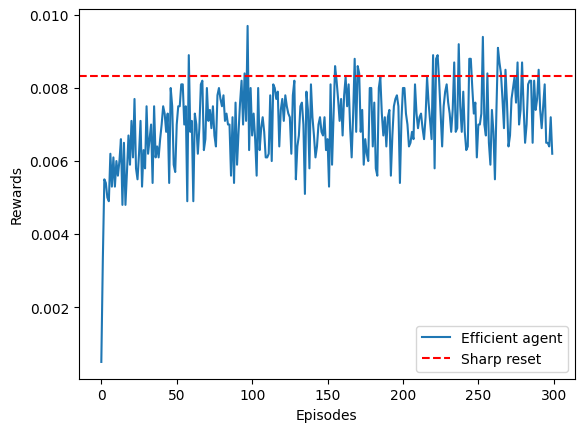

In [ ]:
plt.plot(save_rewards/time_ep, label = 'Efficient agent')


# We compare with the sharp reset efficiency
plt.axhline(efficiency_sharp/length_sharp_run, color = 'red', linestyle = '--', label = 'Sharp reset')


plt.legend()

plt.xlabel('Episodes')
plt.ylabel('Rewards')

As we see, the agent learns, and steadily reaches the sharp baseline! While the proposed set of learning parameters have shown to be quite robust, different runs will yield different training efficiencies. Nonetheless, in average all agents reach the baseline with sufficient episodes at the current target distance.

Now, as we did above, we can take a look at the learned strategy, namely the policy of the agent. In this case, because we have two actions, we will have something more complex:

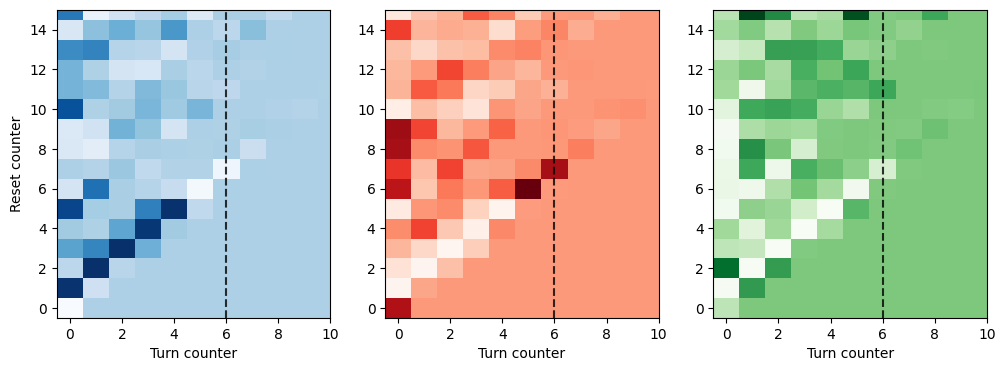

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))


current_dist = env_TurnRes.dist_target

for i, (action, cmap) in enumerate(zip(['continue', 'turn', 'reset'],
                                       ['Blues', 'Reds', 'Greens'])
                                    ):

    m = (TurnReset_agent.h_matrix[i] / TurnReset_agent.h_matrix.sum(0)).reshape(size_state_space)
    
    
    axs[i].matshow(m, cmap = cmap)

    axs[i].xaxis.set_ticks_position("bottom")
    axs[i].invert_yaxis()

    axs[i].axvline(current_dist, ls = '--', c = 'k', alpha = 0.8)

plt.setp(axs, aspect = 'auto', xlim = (-0.5, 10), ylim = (-0.5, 15))
plt.setp(axs[0], ylabel = 'Reset counter')
plt.setp(axs[:], xlabel = 'Turn counter');

These plots, analogous to those of Fig. 5 in our paper, show the behaviour of the agent. As we explain in the paper, there is a very consistent behaviour (you can run the training again to see a very similar result!): the agent has high probability of continuing until the vertical line at $L$, entailing a step of length $L+1$ (python numbering :P). It then turns. Because of the short training, the rest of the behaviour shown in the paper is still to be learned! You can run the trainings longer to see the same clean patter we show in the paper!